## Feature Engineering and Machine Learning

In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
from sklearn import tree
from sklearn.model_selection import GridSearchCV

# Figures inline and set visualization style
%matplotlib inline
sns.set()

# Import data
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

# Store target variable of training data in a safe place
survived_train = df_train.Survived

# Concatenate training and test sets
data = pd.concat([df_train.drop(['Survived'], axis=1), df_test])

# View head
data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Name           1309 non-null object
Sex            1309 non-null object
Age            1046 non-null float64
SibSp          1309 non-null int64
Parch          1309 non-null int64
Ticket         1309 non-null object
Fare           1308 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 122.7+ KB


## Why feature engineer at all?

To extract more information from your data. For example, check out the 'Name' column:

In [3]:
# View tail of 'Name' column
data.tail()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S
417,1309,3,"Peter, Master. Michael J",male,NaN,1,1,2668,22.3583,NaN,C


Notice that this columns contains strings (text) that contain 'Title' such as 'Mr', 'Master' and 'Dona'. You can use regular expressions to extract the Title (to learn more about regular expressions, check out my write up of our last [FB Live code along event](https://www.datacamp.com/community/tutorials/web-scraping-python-nlp)):

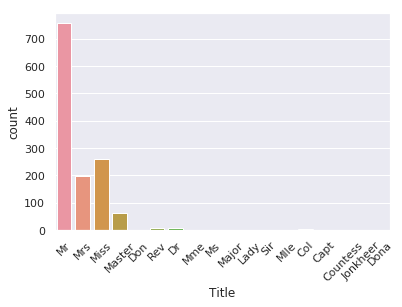

In [4]:
# create a new feature 'Title'
# Extract Title(Mr, Master, Dr, etc) from 'Name', store in 'Title' column and plot barplot
data['Title'] = data.Name.apply(lambda x: re.search(' ([A-Z][a-z]+)\.', x).group(1))
sns.countplot(x='Title', data=data);
plt.xticks(rotation=45);

* There are several titles and it makes sense to put them in fewer buckets:

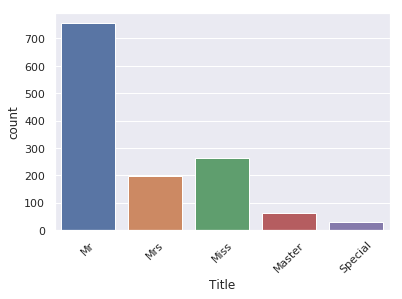

In [5]:
data['Title'] = data['Title'].replace({'Mlle':'Miss', 'Mme':'Mrs', 'Ms':'Miss'})
data['Title'] = data['Title'].replace(['Don', 'Dona', 'Rev', 'Dr',
                                            'Major', 'Lady', 'Sir', 'Col', 'Capt', 'Countess', 'Jonkheer'],'Special')
sns.countplot(x='Title', data=data);
plt.xticks(rotation=45);

* Check out your data again and make sure that we have a 'Title' column:

In [6]:
# View head of data
data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


### Being cabinless may be important

* There are several NaNs (missing values) in the 'Cabin' column. It is reasonable to presume that those NaNs didn't have a cabin, which may tell us something about 'Survival' so now create a new column that encodes this information:

In [7]:
# Did they have a Cabin? (~ flips booleans)
data['has_Cabin'] = ~data.Cabin.isnull()

# View head of data
data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,has_Cabin
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,False
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,True
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,False
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,True
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,False


* Drop columns that contain no more useful information (or that we're not sure what to do with:) `['Cabin', 'Name', 'PassengerId', 'Ticket']`:

In [8]:
# Drop columns and view head
data.drop(['Cabin', 'Name', 'PassengerId', 'Ticket'], axis=1, inplace=True)
data.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,has_Cabin
0,3,male,22.0,1,0,7.2500,S,Mr,False
1,1,female,38.0,1,0,71.2833,C,Mrs,True
2,3,female,26.0,0,0,7.9250,S,Miss,False
3,1,female,35.0,1,0,53.1000,S,Mrs,True
4,3,male,35.0,0,0,8.0500,S,Mr,False


**Recap:**
* You've engineered some new features such as 'Title' and 'Has_Cabin': congrats!

**Up next:** deal with missing values and bin your numerical data, transform all features into numeric variables. Then you'll build your final model for this session.

If you're enoying this session, retweet or share on FB now and follow us on Twitter: [@hugobowne](https://twitter.com/hugobowne) & [@DataCamp](https://twitter.com/datacamp).

### Dealing with missing values

* Figure out if there are any missing values left:

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 9 columns):
Pclass       1309 non-null int64
Sex          1309 non-null object
Age          1046 non-null float64
SibSp        1309 non-null int64
Parch        1309 non-null int64
Fare         1308 non-null float64
Embarked     1307 non-null object
Title        1309 non-null object
has_Cabin    1309 non-null bool
dtypes: bool(1), float64(2), int64(3), object(3)
memory usage: 133.3+ KB


* Impute missing values:

In [10]:
# Impute missing values for Age, Fare, Embarked
data['Age'] = data.Age.fillna(data.Age.median())
data['Fare'] = data.Fare.fillna(data.Fare.median())
data['Embarked'] = data['Embarked'].fillna('S')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 9 columns):
Pclass       1309 non-null int64
Sex          1309 non-null object
Age          1309 non-null float64
SibSp        1309 non-null int64
Parch        1309 non-null int64
Fare         1309 non-null float64
Embarked     1309 non-null object
Title        1309 non-null object
has_Cabin    1309 non-null bool
dtypes: bool(1), float64(2), int64(3), object(3)
memory usage: 133.3+ KB


In [11]:
data.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,has_Cabin
0,3,male,22.0,1,0,7.2500,S,Mr,False
1,1,female,38.0,1,0,71.2833,C,Mrs,True
2,3,female,26.0,0,0,7.9250,S,Miss,False
3,1,female,35.0,1,0,53.1000,S,Mrs,True
4,3,male,35.0,0,0,8.0500,S,Mr,False


### Bin numerical data

* Use the `pandas` function `qcut` to bin your numerical data:

In [12]:
# Binning numerical columns - create ranges for 'Age' and 'Fare' that 
# are represented as categories, 0-3
data['CatAge'] = pd.qcut(data.Age, q=4, labels=False)
data['CatFare']= pd.qcut(data.Fare, q=4, labels=False)
data.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,has_Cabin,CatAge,CatFare
0,3,male,22.0,1,0,7.2500,S,Mr,False,0,0
1,1,female,38.0,1,0,71.2833,C,Mrs,True,3,3
2,3,female,26.0,0,0,7.9250,S,Miss,False,1,1
3,1,female,35.0,1,0,53.1000,S,Mrs,True,2,3
4,3,male,35.0,0,0,8.0500,S,Mr,False,2,1


* You can now safely drop 'Age' and 'Fare' columns:

In [13]:
data = data.drop(['Age', 'Fare'], axis=1)
data.head()

,Pclass,Sex,SibSp,Parch,Embarked,Title,has_Cabin,CatAge,CatFare
0,3,male,1,0,S,Mr,False,0,0
1,1,female,1,0,C,Mrs,True,3,3
2,3,female,0,0,S,Miss,False,1,1
3,1,female,1,0,S,Mrs,True,2,3
4,3,male,0,0,S,Mr,False,2,1


## Create a new column: number of members in family onboard

In [16]:
# Create column of number of Family members onboard
data['Fam_Size'] = data['SibSp'] + data['Parch']
data.head(10)

,Pclass,Sex,SibSp,Parch,Embarked,Title,has_Cabin,CatAge,CatFare,Fam_Size
0,3,male,1,0,S,Mr,False,0,0,1
1,1,female,1,0,C,Mrs,True,3,3,1
2,3,female,0,0,S,Miss,False,1,1,0
3,1,female,1,0,S,Mrs,True,2,3,1
4,3,male,0,0,S,Mr,False,2,1,0
5,3,male,0,0,Q,Mr,False,1,1,0
6,1,male,0,0,S,Mr,True,3,3,0
7,3,male,3,1,S,Master,False,0,2,4
8,3,female,0,2,S,Mrs,False,1,1,2
9,2,female,1,0,C,Mrs,False,0,2,1


In [17]:
# Drop columns
data = data.drop(['SibSp','Parch'], axis=1)
data.head()

,Pclass,Sex,Embarked,Title,has_Cabin,CatAge,CatFare,Fam_Size
0,3,male,S,Mr,False,0,0,1
1,1,female,C,Mrs,True,3,3,1
2,3,female,S,Miss,False,1,1,0
3,1,female,S,Mrs,True,2,3,1
4,3,male,S,Mr,False,2,1,0


## Transform all variables into numerical variables

In [18]:
# Transform into binary variables - True/False are treated as numericals
data_dum = pd.get_dummies(data, drop_first=True)
data_dum.head()

,Pclass,has_Cabin,CatAge,CatFare,Fam_Size,Sex_male,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Special
0,3,False,0,0,1,1,0,1,0,1,0,0
1,1,True,3,3,1,0,0,0,0,0,1,0
2,3,False,1,1,0,0,0,1,1,0,0,0
3,1,True,2,3,1,0,0,1,0,0,1,0
4,3,False,2,1,0,1,0,1,0,1,0,0


**Recap:**
* You've engineered some new features such as 'Title' and 'Has_Cabin';
* You've dealt with missing values, binned your numerical data and transformed all features into numeric variables.

**Up next:**  It's time ... to build your final model!

If you're enoying this session, retweet or share on FB now and follow us on Twitter: [@hugobowne](https://twitter.com/hugobowne) & [@DataCamp](https://twitter.com/datacamp).

## Building models with our new dataset!

* As before, first you'll split your `data` back into training and test sets; then you'll transform them into arrays:

In [19]:
# Split into test.train
data_train = data_dum.iloc[:891]
data_test = data_dum.iloc[891:]

# Transform into arrays for scikit-learn
X = data_train.values
test = data_test.values
y = survived_train.values

You're now going to build a decision tree on your brand new feature-engineered dataset. To choose your hyperparameter `max_depth`, you'll use a variation on test train split called cross validation.

<img src="img/cv.png" width="400">

We begin by splitting the dataset into 5 groups or *folds*. Then we hold out the first fold as a test set, fit our model on the remaining four folds, predict on the test set and compute the metric of interest. Next we hold out the second fold as our test set, fit on the remaining data, predict on the test set and compute the metric of interest. Then similarly with the third, fourth and fifth. 		
 
As a result we get five values of accuracy, from which we can compute statistics	of interest, such as the median and/or mean and 95% confidence intervals. 

We do this for each value of each hyperparameter that we're tuning and choose the set of hyperparameters that performs the best. This is called _grid search_.

* Let's get it! In the following, you'll use cross validation and grid search to choose the best `max_depth` for your new feature engineered dataset:

In [22]:
# Setup the hyperparameter grid
dep = np.arange(1,9)
param_grid = {'max_depth': dep}

# Instantiate a DecisionTreeClassifier: clf
clf = tree.DecisionTreeClassifier()

# Instantiate the GridSearchCV object: clf_cv
clf_cv = GridSearchCV(clf, param_grid=param_grid, cv=5)

# Fit it to the data
clf_cv.fit(X, y)

# Print the tuned parameter and score
print("Tuned Decision Tree Parameters: {}".format(clf_cv.best_params_))
print("Best score is {}".format(clf_cv.best_score_))


Tuned Decision Tree Parameters: {'max_depth': 3}
Best score is 0.8294051627384961


* Make predictions on your test set, create a new column 'Survived' and store your predictions in it. Save 'PassengerId' and 'Survived' columns of `df_test` to a .csv and submit to Kaggle.

In [24]:
Y_pred = clf_cv.predict(test)
df_test['Survived'] = Y_pred
df_test[['PassengerId', 'Survived']].to_csv('data/predictions/dec_tree_feat_eng.csv', index=False)

* What was the accuracy?

_Accuracy_ = 0.78468

## Next steps

See if you can do some more feature engineering and try some new models out to improve on this score. I'll post all of this on github and on the DataCamp community and it would be great to see all of you improve on these models.

There's a lot more pre-processing that you'd like to learn about, such as scaling your data. You'll also find scikit-learn pipelines super useful. Check out our [Supervised Learning with scikit-learn course](https://www.datacamp.com/courses/supervised-learning-with-scikit-learn) and the [scikit-learn docs](http://scikit-learn.org/stable/) for all of this and more.